In [285]:
import torch
import pandas as pd
import numpy as np
from torch import nn
import os
import sklearn
import matplotlib.pyplot as plt
import sys
import re

### For Colab

In [286]:
mps_device = torch.device("mps")

# Create a Tensor directly on the mps device
x = torch.ones(5, device=mps_device)
# Or
x = torch.ones(5, device="mps")

x.device

device(type='mps', index=0)

In [287]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment1/'
# FOLDERNAME = 'PyTorch Test Project/N_TXT'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# # %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# # !bash get_datasets.sh
# # %cd /content/drive/My\ Drive/$FOLDERNAME

In [288]:
# path = "/content/drive/MyDrive/PyTorch Test Project/N_TXT"

# os.chdir(path)

# fx_data = np.array([], dtype=np.float32)

# #gets data from file specified by file_path
# def get_contents(file_path):
#     global fx_data
#     skip_lines = 7

#     with open(file_path,'r') as file:

#         for skips in range(skip_lines):
#             next(file)

#         lines = file.readlines()[:-1]

#         for line in lines:
#             data = line.split()[-1]
#             fx_data = np.append(fx_data, np.float32(data))
#             #print(data)

In [289]:
path = "/Users/jm/VS Code/ML/Time Series Prediction/N_TXT"

os.chdir(path)

fx_data = np.array([], dtype=np.float32)

#gets data from file specified by file_path
def get_contents(file_path):
    global fx_data
    skip_lines = 7

    with open(file_path,'r') as file:

        for skips in range(skip_lines):
            next(file)

        lines = file.readlines()[:-1]

        for line in lines:
            data = line.split()[-1]
            fx_data = np.append(fx_data, np.float32(data))
            #print(data)

In [290]:
#go through all files in directory and extract data from txt files
for file in os.listdir():
    if file.endswith(".txt"):
        file_path = f"{path}/{file}"
        

        print(f"Currently working on: {file_path}")
        get_contents(file_path)

fx_data.dtype

Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/9Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/8Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/1Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/3Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/10Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/2Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/11Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/7Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/6Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/4Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/5Npie.txt


dtype('float32')

In [291]:
#create time "sample" for dataframe
time_data = np.array([], dtype=np.float32)

for x in range(len(fx_data)):
    time_data = np.append(time_data, np.float32(x))
    type(x)

time_data, time_data[0].dtype

(array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.87857e+05,
        1.87858e+05, 1.87859e+05], dtype=float32),
 dtype('float32'))

In [292]:
#create time "sample" for dataframe
dataset = pd.DataFrame({"Time": time_data,
                        "FX Channel": fx_data})
dataset, dataset.size

(            Time  FX Channel
 0            0.0        -0.6
 1            1.0        -0.6
 2            2.0        -0.6
 3            3.0        -0.6
 4            4.0        -0.6
 ...          ...         ...
 187855  187855.0         4.1
 187856  187856.0         4.1
 187857  187857.0         4.1
 187858  187858.0         4.1
 187859  187859.0         4.1
 
 [187860 rows x 2 columns],
 375720)

([<matplotlib.lines.Line2D at 0x359280f40>], pandas.core.frame.DataFrame)

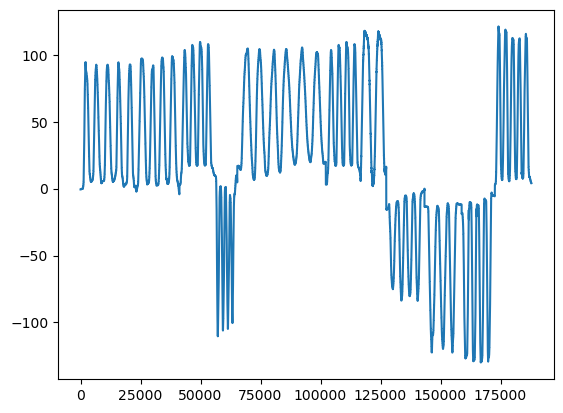

In [293]:
plt.plot(dataset["Time"], dataset["FX Channel"]), type(dataset)

In [294]:
X = dataset["Time"]
y = dataset["FX Channel"]

X

0              0.0
1              1.0
2              2.0
3              3.0
4              4.0
            ...   
187855    187855.0
187856    187856.0
187857    187857.0
187858    187858.0
187859    187859.0
Name: Time, Length: 187860, dtype: float32

In [295]:
#trying to split data loader now? not too sure if this is the best way
split_idx = int(0.8 * len(dataset))

temp_X_train = X[:split_idx]
temp_X_test = X[split_idx:]

temp_y_train = y[:split_idx]
temp_y_test = y[split_idx:]

temp_X_train.shape, temp_X_test.shape, temp_y_train.shape, temp_y_test.shape, len(X), temp_X_train

((150288,),
 (37572,),
 (150288,),
 (37572,),
 187860,
 0              0.0
 1              1.0
 2              2.0
 3              3.0
 4              4.0
             ...   
 150283    150283.0
 150284    150284.0
 150285    150285.0
 150286    150286.0
 150287    150287.0
 Name: Time, Length: 150288, dtype: float32)

In [296]:
def split_data(data, nsteps):
    data_list = list()

    for i in range(len(data)):
        end = i + nsteps
        if(end > len(data-1)):
            break

        extracted_data = data[i:end]

        data_list.append(extracted_data)

    return np.array(data_list)

In [297]:
len(temp_y_train), y[0:8]

(150288,
 0   -0.6
 1   -0.6
 2   -0.6
 3   -0.6
 4   -0.6
 5   -0.6
 6   -0.6
 7   -0.6
 Name: FX Channel, dtype: float32)

In [298]:
nsteps = 3
X_train = split_data(temp_X_train, nsteps)
X_test = split_data(temp_X_test, nsteps)
y_train = split_data(temp_y_train, nsteps)
y_test = split_data(temp_y_test, nsteps)

X_train, type(X_train), len(X_train)

In [ ]:
y_train, len(y_train)

(array([[ -0.6,  -0.6,  -0.6],
        [ -0.6,  -0.6,  -0.6],
        [ -0.6,  -0.6,  -0.6],
        ...,
        [-90.6, -90.7, -90.8],
        [-90.7, -90.8, -90.9],
        [-90.8, -90.9, -90.9]], dtype=float32),
 150286)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

# y_train = scaler.fit_transform(y_train)
# y_test = scaler.fit_transform(y_test)

# X_train.shape, y_train.shape

In [ ]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([150286, 3]),
 torch.Size([37570, 3]),
 torch.Size([150286, 3]),
 torch.Size([37570, 3]))

In [ ]:
type(X_train)

torch.Tensor

In [ ]:
# X_train = X_train.unsqueeze(dim = 2)
# X_test = X_test.unsqueeze(dim = 2)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
#set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([150286, 3]),
 torch.Size([37570, 3]),
 torch.Size([150286, 3]),
 torch.Size([37570, 3]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

train_dataset = TimeSeriesDataset(X_train.reshape(X_train.shape[0],X_train.shape[1],1),y_train)
test_dataset = TimeSeriesDataset(X_test.reshape(X_test.shape[0],X_test.shape[1],1),y_test)

In [ ]:
type(train_dataset)

__main__.TimeSeriesDataset

In [ ]:
from torch.utils.data import DataLoader

#setup batch size hyperparameter
BATCH_SIZE = 64

#turn datasets into iterables (batches)
train_loader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True,
                              drop_last=True)

test_loader = DataLoader(dataset=test_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              drop_last=True)

#check out what we've created
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of train_dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x347e3b7f0>, <torch.utils.data.dataloader.DataLoader object at 0x3408aa080>)
Length of train_dataloader: 2348 batches of 64
Length of train_dataloader: 587 batches of 64


In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 3, 1]) torch.Size([64, 3])


In [ ]:
#set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device

'mps'

In [ ]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(3,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        # print(x.shape)
        #x = x.view(-1)  
        # print(x.shape)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

print(model)

CNN_ForecastNet(
  (conv1d): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        # print(f"shape: {inputs.shape}")
        labels = labels.to(device)
        # print(inputs)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(test_loader)
        valid_losses.append(valid_loss.detach().cpu().numpy())
        print(f'valid_loss {valid_loss}')

In [ ]:
import gc

epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 861174.75
valid_loss 8331.40234375
epochs 2/200
train_loss 3233.43408203125
valid_loss 6994.3720703125
epochs 3/200


KeyboardInterrupt: 

In [ ]:
plt.plot(train_acc, label='Train Acc')
plt.plot(test_acc, label='Test Acc')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'train_acc' is not defined

In [ ]:
target_x = split_data(X, nsteps)
target_y = split_data(y, nsteps)

inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [ ]:
model.eval()
prediction = []
batch_size = 64
iterations =  int(inputs.shape[0]/batch_size)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).to(device).float())
    # print(preds.squeeze().shape)
    prediction.append(preds.detach().squeeze().cpu().numpy())

In [ ]:
len(prediction),

(2935,)

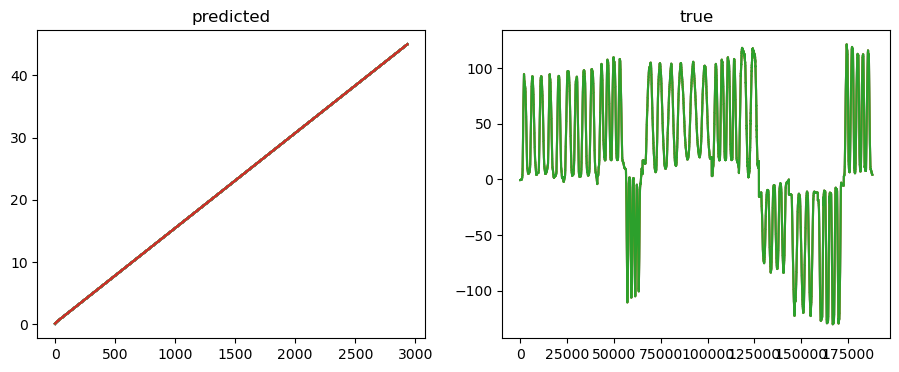

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted')
ax[0].plot(prediction)
ax[1].set_title('true')
ax[1].plot(target_y)
plt.show()

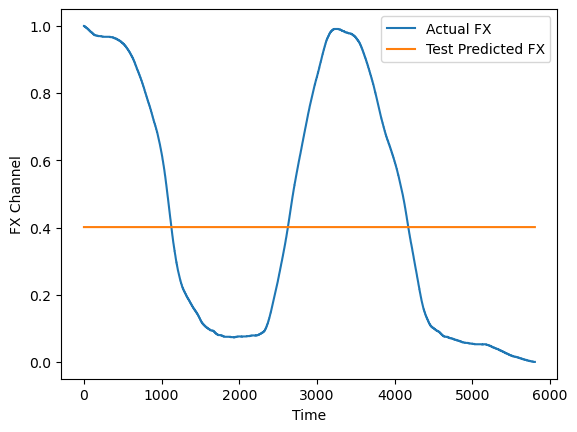

In [ ]:
model.eval()
with torch.inference_mode():
    test_pred = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual FX')
plt.plot(test_pred.squeeze(), label='Test Predicted FX')
plt.xlabel('Time')
plt.ylabel('FX Channel')
plt.legend()
plt.show()

In [ ]:
test_pred.squeeze().shape

(5807, 64)

In [ ]:
X_test.shape, X_test[0]

(torch.Size([5807, 8, 1]),
 tensor([[23226.],
         [23227.],
         [23228.],
         [23229.],
         [23230.],
         [23231.],
         [23232.],
         [23233.]]))

In [ ]:
temp = torch.arange(0, 1, 0.000016)
temp = temp.unsqueeze(dim=1)
temp.shape

torch.Size([62500, 1])

In [ ]:
model.eval()
with torch.inference_mode():
    test_pred = model(temp.unsqueeze(dim=1)).to('cpu').numpy()

# plt.xlim(0, (10000))
# plt.ylim(-0, 1)
# plt.autoscale(False)
plt.plot(y_test, label='Actual FX')
plt.plot(test_pred, label='Test Predicted FX')
plt.xlabel('Time')
plt.ylabel('FX Channel')
plt.legend()
plt.show()

RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cpu and hidden tensor at mps:0

ValueError: x and y can be no greater than 2D, but have shapes (5807,) and (5807, 64, 1)

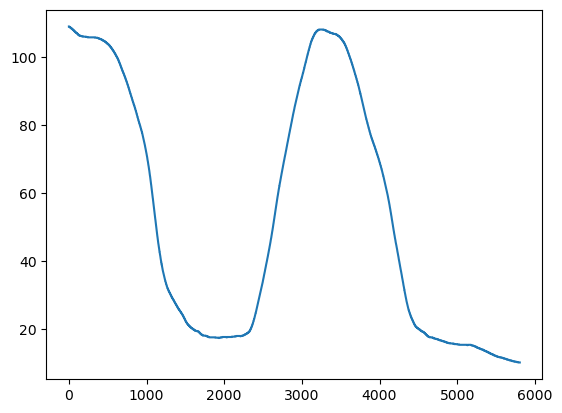

In [ ]:
model.eval()
with torch.inference_mode():
    test_pred = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual FX')
plt.plot(test_pred, label='Test Predicted FX')
plt.xlabel('Time')
plt.ylabel('FX Channel')
plt.legend()
plt.show()

In [ ]:
y_test[0], y_test[5800], y_train[0], y_train[23000]

(tensor([0.9934]), tensor([0.0665]), tensor([0.]), tensor([0.9775]))

In [ ]:
X_test.max(), X_test.min()

(tensor(1.0000), tensor(0.8000))